In [22]:
#import libraries   
from scapy.all import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [23]:
## load dump file, then save the first N packets in a new dump file to easier reading if it doesn't exist
Npackets=5000
if not os.path.exists(f'packets{Npackets}.dump'):
    packets_reader=PcapReader('packets.dump')
    packets=[]
    for index,packet in enumerate(packets_reader):
        packets.append(packet)
        if index==Npackets:
            break
    packets_reader.close()
    wrpcap(f'packets{Npackets}.dump',packets)




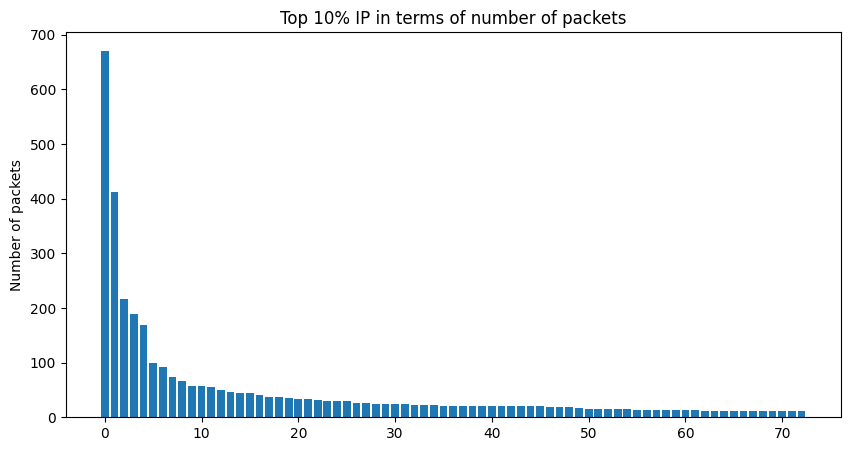

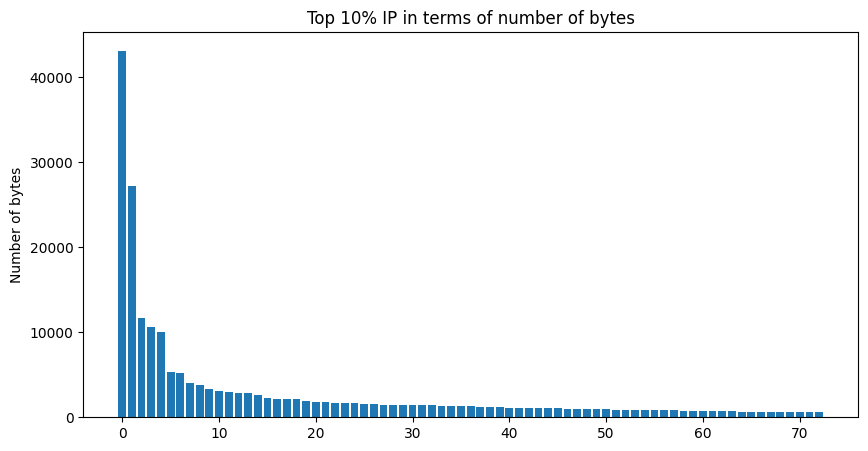

Number of packets that are the same in both lists: 68
216.105.134.93
223.44.143.214
147.59.130.221
202.145.138.230
164.96.219.65
203.45.191.72
152.144.241.57
203.35.34.89
202.168.207.93
134.68.182.106
203.35.45.187
33.162.19.116
152.144.135.220
220.248.54.139
208.132.8.98
203.45.191.78
161.57.24.62
212.167.15.51
203.45.191.80
161.57.5.237
202.145.132.54
147.59.184.161
129.148.142.140
216.105.134.92
202.145.131.200
134.110.9.156
220.254.234.14
197.81.218.93
203.45.188.244
41.32.214.212
161.57.219.255
214.52.129.160
223.67.240.181
164.96.219.64
6.162.65.182
128.94.205.241
152.144.250.221
218.174.180.48
203.35.40.155
134.161.222.237
134.110.8.90
147.59.208.81
212.167.13.46
203.112.228.113
147.59.195.187
129.148.209.84
33.162.19.96
41.209.213.250
203.81.235.170
222.53.176.29
152.144.227.1
36.10.64.243
134.68.194.193
203.154.140.51
134.110.9.158
208.223.98.225
147.59.184.54
128.10.143.94
161.57.25.168
128.10.143.88
219.45.144.124
196.157.74.236
54.67.248.197
223.47.194.169
39.173.126.233
12

In [39]:
#Read the dump file
packets=rdpcap('packets5000.dump')

#Plots the ip per number of packets
ip_packets={}
for packet in packets:
    if packet.haslayer(IP):
        ip=packet[IP].src
        if ip  in ip_packets:
            ip_packets[ip]=[ip_packets[ip][0]+1,ip_packets[ip][1]+len(packet)]
        else:
            ip_packets[ip]=[1,len(packet)]
#select the top 10% packets in terms of number of packets 
top_10_Npackets=sorted(ip_packets.items(), key=lambda x: x[1][0], reverse=True)[:len(ip_packets)//10]
#select the top 10% packets in terms of number of bytes
top_10_Nbytes=sorted(ip_packets.items(), key=lambda x: x[1][1], reverse=True)[:len(ip_packets)//10]

#plot the top 10% IP in terms of number of packets 
plt.figure(figsize=(10,5))
plt.bar(np.arange(len(top_10_Npackets)),[x[1][0] for x in top_10_Npackets])
plt.title('Top 10% IP in terms of number of packets')
plt.ylabel('Number of packets')
plt.show()

#plot the top 10% IP in terms of number of bytes
plt.figure(figsize=(10,5))
plt.bar(np.arange(len(top_10_Npackets)),[x[1][1] for x in top_10_Nbytes])
plt.title('Top 10% IP in terms of number of bytes')
plt.ylabel('Number of bytes')
plt.show()

#check the number of IP that are the same in both lists
total_top_IPs=set([x[0] for x in top_10_Npackets]).intersection(set([x[0] for x in top_10_Nbytes]))
print('Number of packets that are the same in both lists:',len(total_top_IPs))
for IP in total_top_IPs:
    print(IP)
        



In [40]:
#create a dataset containing the packet header in bit as X and if it's in that list  the label as y
X=[]
y=[]
for packet in packets:
    if packet.haslayer(IP):
        ip=packet[IP].src
        packet=bytes(packet)
        bits = np.unpackbits(np.frombuffer(packet, dtype=np.uint8))
        if ip in [x[0] for x in top_10_Nbytes]:
            X.append(bits)
            y.append(1)
        else:
            X.append(bits)
            y.append(0)
pandas_dataset=pd.DataFrame({'packet':X,'label':y})
pandas_dataset.to_csv('dataset.csv',index=False)
